# **Data preparation**

In [1]:
!pip install pyheif pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 66.4 MB/s eta 0:00:00


In [2]:
# transform data
# transform data
import torchvision.transforms.v2 as T
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os
import glob

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.io import decode_image

In [3]:
import random
data_dir = "/kaggle/input/handwritten-tl/digits_data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
print(os.path.exists(train_dir), os.path.exists(val_dir))

# origin_train_list = [img for img in glob.glob(train_dir + "/*/*") if os.path.isfile(img)]
# origin_val_list = [img for img in glob.glob(val_dir + "/*/*") if os.path.isfile(img)]
origin_train_list = glob.glob(train_dir + "/*/*")
origin_val_list = glob.glob(val_dir + "/*/*")
train_list = origin_train_list[:]
val_list = origin_val_list[:]
random.shuffle(train_list)
random.shuffle(val_list)
print(f"train: {len(train_list)}, val: {len(val_list)}")


True True
train: 5917, val: 1354


In [4]:
# function to process data: gray_100x100_norm
# DO NOT CHANGE IN THE SAME DATA VERSION
transform = transforms.v2.Compose([
    T.ToImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((100, 100)),
    # T.RandomRotation(10),
    # T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    # T.ColorJitter(brightness=0.25, contrast=0.5),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.5], std=[0.5]),  # Cân chỉnh lại nếu bạn có thống kê cụ thể hơn
])


# Transform cho dữ liệu train và validation
train_transform = T.Compose([
    T.ToImage(),                            # Chuyển sang định dạng tensor
    T.Grayscale(num_output_channels=3),     # Chuyển ảnh xám sang 3 kênh để tương thích với EfficientNet
    T.Resize((384, 384)),                   # Resize về kích thước 384x384 (yêu cầu của EfficientNetV2-S)
    T.RandomRotation(10),                   # Augmentation: xoay ngẫu nhiên ±10 độ
    T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Dịch chuyển và thay đổi tỷ lệ
    T.ColorJitter(brightness=0.25, contrast=0.5),  # Thay đổi độ sáng và độ tương phản
    T.ToDtype(torch.float32, scale=True),   # Chuyển sang float32 và scale về [0, 1]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa theo ImageNet
])

# Transform cho dữ liệu test (không augmentation)
test_transform = T.Compose([
    T.ToImage(),
    T.Grayscale(num_output_channels=3),
    T.Resize((384, 384)),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [5]:
import pyheif
import torch


def convert_heic_to_jpeg(heic_path, jpeg_path):
    try:
        heif_file = pyheif.read(heic_path)
        image = Image.frombytes(
            heif_file.mode, 
            heif_file.size, 
            heif_file.data, 
            "raw", 
            heif_file.mode, 
            heif_file.stride,
        )
        image.save(jpeg_path, format="JPEG")
    except Exception as e:
        print(f"\t🛑 Lỗi chuyển đổi .heic: {heic_path} — {e}")


In [6]:
import shutil



def read_heic(img_path):
    jpeg_path = "heic2jpeg/" + img_path.split("/")[-1].replace(".HEIC", ".jpeg")
    convert_heic_to_jpeg(img_path, jpeg_path)
    image = read_image(jpeg_path, mode="RGB")
    return image
    

class custom_image_dataset(torch.utils.data.IterableDataset):
    def __init__(self, image_lists, transform=None, test=False):
        # self.img_labels = pd.read_csv(annotations_file)
        self.image_lists = image_lists
        self.transform = transform
        self.test = test

    def __read_image(self, img_path):
        try:
          if img_path.endswith(".HEIC"):
              image = read_heic(img_path)
              if image is not None:
                  print("--> Converted to JPEG")
              else:
                  print("--> Can't convert to JPEG")
          elif img_path.endswith(".md"):
              print("Found markdown")
              return None
          else:
              image = read_image(img_path, mode="RGB")
          truth = -1
          if not self.test:
              label_str = os.path.basename(img_path).split("_")[1]  
              truth = torch.tensor(int(label_str))
              
          if self.transform:
              image = self.transform(image)
          return image, truth, img_path # Path sẽ rất cần để debug
        except Exception as e:
          print(f"\t**Error reading imgs: {e} - for: {img_path}")
          return None

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = 0
            iter_end = len(self.image_lists)
        else:  # in a worker process
            # split workload
            per_worker = int(len(self.image_lists) / float(worker_info.num_workers))
            worker_id = worker_info.id
            iter_start =  worker_id * per_worker
            iter_end = min(iter_start + per_worker, len(self.image_lists))
        return iter(
            filter(lambda x : x is not None
                  , map(self.__read_image, self.image_lists[iter_start : iter_end] )
            )
        )

    def __len__(self):
        return len(self.image_lists)



In [7]:
def clear_heic2jpeg():
    if not os.path.exists("heic2jpeg"):
        os.makedirs("heic2jpeg")
    else:
        shutil.rmtree("heic2jpeg")
        print("deleted old folder 'heic2jpeg'")
        os.makedirs("heic2jpeg")
        print("Created new 'heic2jpeg'")


clear_heic2jpeg()


label: 7
/kaggle/input/handwritten-tl/digits_data/train/7/train_7_7_b_002_0135.jpg


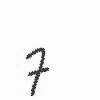

In [8]:
temp = custom_image_dataset(train_list[:10], transform=transform)
it = iter(temp)
img, truth, path = next(it)

print(f"label: {truth}")
print(path)

display(to_pil_image(img))


In [9]:
BATCH_SIZE = 128
num_workers = os.cpu_count()
print(f"Num workers: {num_workers}")
trainset = custom_image_dataset(train_list,transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=num_workers)

valset = custom_image_dataset(val_list, transform=test_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=num_workers)

classes = [i for i in range(10)]
classes

Num workers: 4


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# **Model config**

In [10]:
import sys
from tqdm import tqdm
import logging
from contextlib import redirect_stdout

# Ghi cả ra file và màn hình
class DualWriter:
    def __init__(self, file):
        self.file = file
        self.stdout = sys.__stdout__  # console thật

    def write(self, text):
        self.stdout.write(text)
        self.file.write(text)

    def flush(self):
        self.stdout.flush()
        self.file.flush()

class SaveBestModel:
    def __init__(self, save_path="best_model.pth", mode='min'):
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.save_path = save_path
        self.mode = mode

    def __call__(self, current_value, model):
        is_better = current_value < self.best_value if self.mode == 'min' else current_value > self.best_value
        if is_better:
            self.best_value = current_value
            torch.save(model.state_dict(), self.save_path)
            print(f"✅ Saved new best model ({self.mode} = {current_value:.4f})")

class EarlyStopping:
    def __init__(self, patience=5, mode='min'):
        self.patience = patience
        self.counter = 0
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.early_stop = False
        self.mode = mode

    def __call__(self, current_value):
        is_better = current_value < self.best_value if self.mode == 'min' else current_value > self.best_value

        if is_better:
            self.best_value = current_value
            self.counter = 0
        else:
            self.counter += 1
            print(f"⚠️ No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    


In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class EfficientNetV2S(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(EfficientNetV2S, self).__init__()
        # Tải mô hình EfficientNetV2-S pre-trained
        self.model = models.efficientnet_v2_s(weights='IMAGENET1K_V1' if pretrained else None)
        
        # Đóng băng các tham số của mô hình pre-trained (nếu muốn)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Thay thế lớp fully connected cuối cùng
        # EfficientNetV2-S có lớp cuối là Linear(in_features=1280, out_features=1000) (ImageNet có 1000 lớp)
        # Ta thay bằng Linear(in_features=1280, out_features=num_classes)
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),  # Giữ dropout như trong mô hình gốc
            nn.Linear(1280, num_classes)      # Thay đổi đầu ra thành num_classes
        )
        
        # Mở khóa các tham số của lớp classifier để huấn luyện
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

# Khởi tạo mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2S(num_classes=10, pretrained=True).to(device)

# Định nghĩa loss function và optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Chỉ tối ưu hóa lớp classifier

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 213MB/s]


In [12]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Số tham số huấn luyện được: {trainable_params}")





Số tham số huấn luyện được: 12810


In [13]:
import time
if os.path.exists('train_log.txt'):
    os.remove('train_log.txt')
    print("Deleted old 'train_log'.")
# Ghi log ra log.txt
log_file = open("train_log.txt", "a")  # mở log file
dual_output = DualWriter(log_file)
save_best_model = SaveBestModel("best_model.pth", mode='min')
early_stopping = EarlyStopping(patience=5, mode='min')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
model.to(device)
start_time = time.time()


with redirect_stdout(dual_output):
    for epoch in tqdm(range(2), desc="Epochs: "):  # loop over the dataset multiple times
        running_loss = 0.0
        print()
        epoch_start = time.time()
        for i, data in enumerate(trainloader, 0):
            inputs, labels, _ = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(inputs.device, labels.device, next(net.parameters()).device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        print(f"Epoch {epoch+1} loss: {epoch_loss:.4f} - time: {time.time() - epoch_start}s")

        # Gọi callback
        save_best_model(epoch_loss, model)
        early_stopping(epoch_loss)
        
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered.")
            break

    total_time = time.time() - start_time
    print(f'Finished Training in: {total_time}s')
    
print("🟢 Đã ra khỏi with, chỉ in ra console, không ghi file")
log_file.close()


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Using: cuda



Epochs:  50%|█████     | 1/2 [03:36<03:36, 216.63s/it]

Epoch 1 loss: 2.1974 - time: 216.4623851776123s
✅ Saved new best model (min = 2.1974)



Epochs: 100%|██████████| 2/2 [07:10<00:00, 215.50s/it]

🟢 Đã ra khỏi with, chỉ in ra console, không ghi file


In [14]:
#validate
if not os.path.exists("heic2jpeg"):
    os.makedirs("heic2jpeg")
else:
    shutil.rmtree("heic2jpeg")
    print("deleted old folder 'heic2jpeg'")
    os.makedirs("heic2jpeg")
    print("Created new 'heic2jpeg'")



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2S(num_classes=10, pretrained=True)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)

model.eval()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels,_ = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')


deleted old folder 'heic2jpeg'
Created new 'heic2jpeg'
Accuracy of the network on the test images: 36.69 %


# **PREDICT**

In [15]:
# PREDICT
clear_heic2jpeg()
test_dir = "/kaggle/input/handwritten-test-cs114"
test_list = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
print(f"samples: {len(test_list)}")
testset = custom_image_dataset(test_list, transform=test_transform, test=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE, num_workers=num_workers)

predict_txt = ""
with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # save
        for path, pred in zip(paths, predicted):
            path = path.replace(test_dir, "").lstrip(os.sep)  # Strip test_dir and leading separator
            predict_txt += f"{path},{pred.item()}\n"

# Write to file in text mode
with open("/kaggle/working/predict.txt", "w") as file:
    file.write(predict_txt)
print("Predictions saved in 'predict.txt'")

deleted old folder 'heic2jpeg'
Created new 'heic2jpeg'
samples: 2939
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
Found markdown
Found markdown
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
Predictions saved in 'predict.txt'


label: -1
/kaggle/input/handwritten-test-cs114/389269258327f495063eeb7863aeb323  -.jpg


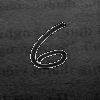

In [16]:
temp = custom_image_dataset(test_list[:10], transform=transform, test=True)
it = iter(temp)
img, truth, path = next(it)


print(f"label: {truth}")
print(path)

display(to_pil_image(img))

# **PREDICT 10K**

In [17]:
# PREDICT
clear_heic2jpeg()
test_dir = "/kaggle/input/handwritten-test-10k"
test_list = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
print(f"samples: {len(test_list)}")
testset = custom_image_dataset(test_list, transform=test_transform, test=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE, num_workers=num_workers)

predict_txt = ""
with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # save
        for path, pred in zip(paths, predicted):
            path = path.replace(test_dir, "").lstrip(os.sep)  # Strip test_dir and leading separator
            predict_txt += f"{path},{pred.item()}\n"

# Write to file in text mode
with open("/kaggle/working/predict_10k.txt", "w") as file:
    file.write(predict_txt)
print("Predictions saved in 'predict_10k.txt'")


deleted old folder 'heic2jpeg'
Created new 'heic2jpeg'
samples: 9974
Predictions saved in 'predict_10k.txt'


label: -1
/kaggle/input/handwritten-test-10k/167144297687438af7bff077e768440c.jpg


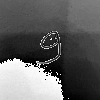

In [18]:
temp = custom_image_dataset(test_list[:10], transform=transform, test=True)
it = iter(temp)
img, truth, path = next(it)


print(f"label: {truth}")
print(path)

display(to_pil_image(img))

# **Save**

In [19]:
log_path = "train_log.txt"
with open(log_path, "a") as f:
    f.write("\n\n" + "="*60 + "\n")
    f.write("Training Summary\n")
    f.write("="*60 + "\n")
    f.write(f"Time: {total_time//60:.0f}m {total_time%60:.0f}s\n")
    f.write(f"Best Validation Accuracy: {accuracy:.4f}\n")
    f.write(f"\nOptimizer: {optimizer.__class__.__name__} - {optimizer.state_dict()['param_groups'][0]}\n")
    f.write(f"Loss Function: {criterion.__class__.__name__}\n")
    f.write("="*60 + "\n\n")

In [20]:
!zip -r working.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/best_model.pth (deflated 7%)
  adding: kaggle/working/predict.txt (deflated 50%)
  adding: kaggle/working/__notebook__.ipynb (deflated 65%)
  adding: kaggle/working/heic2jpeg/ (stored 0%)
  adding: kaggle/working/train_log.txt (deflated 56%)
  adding: kaggle/working/predict_10k.txt (deflated 47%)


In [21]:
os.remove("working.zip")

# **TEST**

In [ ]:
whats_new = """
- first transfer learning with EfficientNetV2-S
- Preprocess match with EfficientNetV2-S input format
-JUST 2 EPOCHS
"""

In [23]:
heics = glob.glob("/kaggle/input/handwritten-test-cs114/*.HEIC")
print(len(heics))
heics2jpegs = glob.glob("/kaggle/working/heic2jpeg/*")
print(len(heics2jpegs))

30
0
